In [ ]:
DATA_NAME = "abeauty"
MODEL_NAME = f"NCF_{DATA_NAME}"
LEARNING_TYPE = "pointwise"
TRN_NEG_PER_POS = 1
TRN_BATCH_SIZE = 128

# WORK_DIR_PATH = "../.."

from google.colab import drive
drive.mount('/content/drive')
WORK_DIR_PATH = "/content/drive/MyDrive/RS-NeuMF/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constants

In [ ]:
# split
EVAL_NEG_PER_POS = 99
EVAL_BATCH_SIZE = 1000
DATA_LOADING_TYPE = "general"
FILTER_BY = "user"
TRN_VAL_TST_RATIO = [0.8, 0.1, 0.1]
NEG_PER_POS = [TRN_NEG_PER_POS, TRN_NEG_PER_POS, EVAL_NEG_PER_POS, EVAL_NEG_PER_POS]
BATCH_SIZE = [TRN_BATCH_SIZE, TRN_BATCH_SIZE, EVAL_BATCH_SIZE, EVAL_BATCH_SIZE]
MAX_HIST = None
SHUFFLE = False if DATA_LOADING_TYPE=="curriculum" else True

# Model
N_FACTORS = 32
HIDDEN = [N_FACTORS*2, N_FACTORS*2, N_FACTORS, N_FACTORS // 2]
DROPOUT = 0.2

# how to learn
LEARNING_RATE = 1e-4
LAMBDA_ = 1e-2

# how to monitor
PATIENCE = 10
MIN_DELTA = 1e-3

# how to loop
N_EPOCHS = 1000
INTERVAL = 10

# Config

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(WORK_DIR_PATH)
print(f"DIRECTORY: {os.getcwd()}")

DIRECTORY: /content/drive/MyDrive/RS-NeuMF


In [27]:
import pandas as pd
import torch
from NeuMF import neumf
import UTILS
from LOOP.loop import TrainingLoop
from LOOP.monitor.predictor import predict
from LOOP.monitor.monitor import EarlyStoppingMonitor
from LOOP.metric.ranking import ndcg_at_k as metric_fn
from LOOP.metric.ranking import top_k_loop

In [ ]:
if LEARNING_TYPE=="pairwise":
    from DATA_SPLITTER.pairwise import trn_val_tst
    from LOOP.trainer.pairwise import PairwiseTrainer as Trainer
    from LOOP.loss_fn.bpr import bpr as task_fn

elif LEARNING_TYPE=="pointwise":
    from DATA_SPLITTER.pointwise import trn_val_tst
    from LOOP.trainer.pointwise import PointwiseTrainer as Trainer
    from LOOP.loss_fn.bce import bce as task_fn

else:
    ValueError

In [29]:
from UTILS.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    COL_DICT,
    DEFAULT_K,
    DEFAULT_THRESHOLD,
    SEED,
)

In [30]:
# seed
UTILS.seed.reset()

SETTING ALL SEEDS TO 42...
ALL SEEDS SET


In [31]:
# Available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preparation

In [ ]:
data = pd.read_csv(f"./_data/{DATA_NAME}.csv")

In [35]:
# Number of user, item
N_USERS = data[DEFAULT_USER_COL].nunique()
N_ITEMS = data[DEFAULT_ITEM_COL].nunique()

In [36]:
# data Description
UTILS.data_handler.description(data)

number of user: 3819
number of item: 1581
total interaction: 34278
interaction density: 0.5677 %
max interaction of user: 127
top 10.0 % interaction of user: 15.0
mean interaction of user: 8
mean interaction of item: 21


In [37]:
kwargs = dict(
    origin=data,
    n_users=N_USERS,
    n_items=N_ITEMS,
    loading_type=DATA_LOADING_TYPE,
)

dataloader = trn_val_tst.DataSplitter(**kwargs)

In [38]:
kwargs = dict(
    filter_by=FILTER_BY,
    trn_val_tst_ratio=TRN_VAL_TST_RATIO,
    neg_per_pos=NEG_PER_POS,
    batch_size=BATCH_SIZE,
    max_hist=MAX_HIST,
    shuffle=SHUFFLE,
)

loaders, interactions, histories = dataloader.get(**kwargs)

In [39]:
trn_loader, val_loader, tst_loader, loo_loader = loaders

# Modeling

In [40]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    n_factors=N_FACTORS,
    hidden=HIDDEN,
    dropout=DROPOUT,
)

model = neumf.ncf.Module(**kwargs)

In [41]:
kwargs = dict(
    model=model,
    task_fn=task_fn,
    lr=LEARNING_RATE,
    lambda_=LAMBDA_
)

trainer = Trainer(**kwargs)

In [42]:
kwargs = dict(
    model=model,
    metric_fn=metric_fn,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

monitor = EarlyStoppingMonitor(**kwargs)

In [43]:
kwargs = dict(
    model=model,
    trainer=trainer,
    monitor=monitor,
)

loop = TrainingLoop(**kwargs)

# Train

In [44]:
kwargs = dict(
    trn_loader=trn_loader,
    val_loader=val_loader,
    loo_loader=loo_loader,
    n_epochs=N_EPOCHS,
    interval=INTERVAL,
)

history = loop.fit(**kwargs)

LEAVE ONE OUT BEST EPOCH: 530
LEAVE ONE OUT BEST SCORE (ndcg@10): 0.4547
MEAN OF PER EPOCH (/s): 1.6655


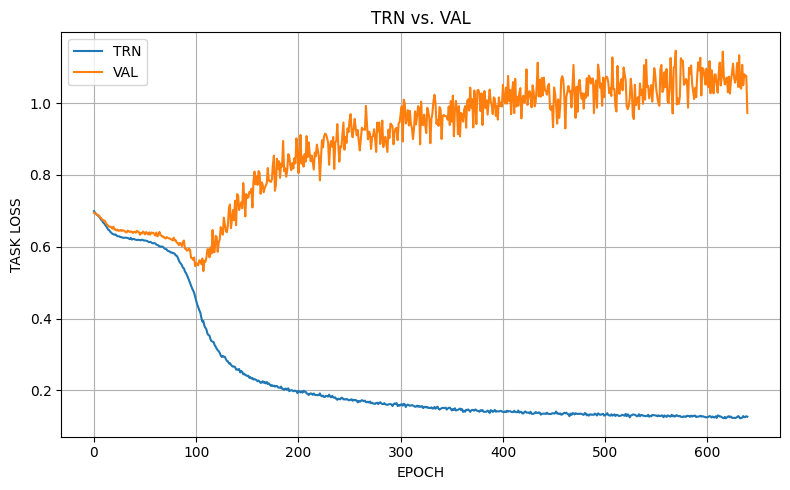

In [45]:
UTILS.visualizer.loss_plot(history, 'TASK LOSS')

# Test

In [46]:
kwargs = dict(
    model=model,
    dataloader=tst_loader,
)

result = predict(**kwargs)

TST: 100%|██████████| 2730/2730 [00:03<00:00, 875.99it/s]


In [50]:
user_max = result["userId"].value_counts().idxmax()
result[result["userId"]==user_max].sort_values(by="prediction", ascending=False).head(10)

,userId,itemId,label,prediction
178664,1878,688,0.0,0.977226
97092,1878,688,0.0,0.977226
17081,1878,273,0.0,0.975670
231353,1878,273,0.0,0.975670
35945,1878,410,1.0,0.975617
46183,1878,816,0.0,0.973156
124473,1878,1477,0.0,0.972958
47190,1878,443,0.0,0.971832
137659,1878,1184,0.0,0.971615
257513,1878,1412,0.0,0.971162


In [47]:
eval = top_k_loop(result)
eval

,top_k,hit_ratio,precision,recall,map,ndcg
0,5,0.522085,0.109187,0.494023,0.417394,0.439883
1,10,0.591873,0.062721,0.561091,0.426992,0.462276
2,15,0.645760,0.045907,0.612328,0.431287,0.476406
3,20,0.694346,0.037213,0.660622,0.434155,0.488140
4,25,0.743375,0.031979,0.708258,0.436351,0.498881
5,50,0.895318,0.019664,0.863854,0.441155,0.529933
6,100,0.998675,0.011391,0.980724,0.443246,0.550319


# Save

In [ ]:
PATH = f'./_checkpoints/{LEARNING_TYPE}_{INTERVAL}_{TRN_BATCH_SIZE}_{TRN_NEG_PER_POS}/{MODEL_NAME}.pth'

kwargs = dict(
    model=model,
    path=PATH,
)

UTILS.checkpointer.save(**kwargs)